# Who is Exposed to Coastal Hazards in Puerto Rico?

### Contributors:
- Deborah Balk 
- Kytt MacManus
- Hieu Tran
- Camilla Greene
- Shemontee Chowdhury

### Language:
- Python/Jupyter Book

### Datasets:
- GHS-Built
- LECZ
- NHGIS
- LiDAR SAR

### Areas of Interest (AOIs):
- Puerto Rico (PRI)

### Functions:
- Image segmentation
- Validation with SAR or LiDAR

# Overview

In this lesson, you will use the dataset delineating [Low Elevation Coastal Zones](https://sedac.ciesin.columbia.edu/data/set/lecz-low-elevation-coastal-zones) from the NASA Socioeconomic Data and Applications Center (SEDAC) website along with census data from the [US Census Bureau](https://www.census.gov/data.html). 

You will perform various preprocessing tasks to prepare the raw spatial data for analysis. These steps include exploring the dataset with visualizations and thematic mapping tools. You will then learn how to generate summary statistics based on combinations of these two layers, over two different time periods. 

You will learn how to perform numerous data manipulations, create statistical summaries of population-at-risk (and related housing characteristics), and examine a decade of change throughout this lesson.

# Learning Objectives

- Become familiar with Low Elevation Coastal Zones (LECZs) and explain their significance (as well as limitations) in assessing coastal hazard exposure.
- Access, integrate, explore, and use LECZ data from NASA SEDAC and demographic data from the US Census Bureau for Puerto Rico.
- Assess decadal changes (2010–2020) in population and housing characteristics in coastal versus non-coastal zones in Puerto Rico.
- Create regional and local scale maps and statistical figures of exposure and decadal change.
- Identify venues for sharing output (for example, discussion board associated with data, policy briefs, op-eds).

# Introduction

Low Elevation Coastal Zones (LECZs) have been defined globally, with population estimates for areas below 5m and 10m elevations (McGranahan et al. 2007, MacManus et al. 2021). In the continental U.S. (CONUS), 1 in 10 people live in the 10m LECZ, and studies highlight that urban residents, people of color, and older adults are disproportionately exposed. For instance, about 1 in 5 urban Black residents live in this zone (Tagtachian and Balk 2023, Hauer et al. 2020).

However, many studies focus exclusively on CONUS, excluding U.S. territories like Puerto Rico, Alaska, and Hawaii, even though they share similar statistical infrastructure and have considerable coastal exposure due to their long coastlines and low elevations.

The omission of territories often stems from limitations in data or computational resources. Some U.S. territories, such as Guam and the U.S. Virgin Islands, lack detailed housing data, and the American Community Survey is not conducted there. Satellite data, such as from SRTM, may also have lower accuracy in polar regions. Additionally, different map projections in territories pose computational challenges when processing spatial data.


###Required packages to run this lesson

```
impumspy
dotenv
pandas
arcgis
zipfile
```

###Optional packages

```
glob
geopandas
earthaccess
```


In [1]:
from ipumspy import readers, ddi, IpumsApiClient, AggregateDataExtract, Dataset, DatasetMetadata
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from matplotlib.ticker import FuncFormatter
import arcgis
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.raster import Raster
from arcgis.features import GeoAccessor
from arcgis.map.renderers import (
    ClassBreaksRenderer,
    ClassBreakInfo,
    UniqueValueRenderer,
    UniqueValueInfo,
    SizeInfoVisualVariable,
)

from arcgis.map.symbols import SimpleLineSymbolEsriSLS, SimpleFillSymbolEsriSFS

import geopandas as gpd
import glob
from zipfile import ZipFile
import earthaccess as ea
import requests
import pprint

c:\Users\hidey\anaconda3\envs\dev-env\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Check the arcgis version for mapping properly 

arcgis.__version__

Using IPUMS API to pull U.S Census Data


In [ ]:
#Load the IPUMS API key from the .env file

load_dotenv()

IPUMS_API_KEY = os.getenv("IPUMS_API_KEY")
ipums = IpumsApiClient(IPUMS_API_KEY)

Run when you do not have data downloaded to your local drive.

In [ ]:
#Getting shapefile metadata in order to get the filename for downloading the shapefile in the above chunk

for page in ipums.get_metadata_catalog("nhgis", metadata_type="shapefiles"):
    for shapefile in page["data"]:
        if shapefile["extent"] == "Puerto Rico":
            if shapefile["geographicLevel"] == "Block Group" and shapefile["year"] == "2010":
                print( "Name: " + shapefile["name"] + " | Year: " + shapefile["year"])

In [ ]:
#Submit extraction data to IPUMS portal

extract = AggregateDataExtract(
    collection="nhgis",
    description="Puerto Rico 2010-2020 vacancy",
    # datasets=[
    #     Dataset(name="2010_SF1a", data_tables=["H1", "H3"], geog_levels=["blck_grp"]),
    #     Dataset(name = "2020_DHCa", data_tables = ["H1", "H3"], geog_levels = ["blck_grp"]),
    # ],
    # geographic_extents=["720"],
    shapefiles=["720_blck_grp_2020_tl2020"] #Get the shapefile name from below chunk
)

In [ ]:
#Submit the extract request
ipums.submit_extract(extract)
print(f"Extract ID: {extract.extract_id}")

#Wait for the extract to finish
ipums.wait_for_extract(extract)

#Download the extract
current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data/county_data")
ipums.download_extract(extract, download_dir=DOWNLOAD_DIR)

In [ ]:

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data/county_data")

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[0]}"
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

# Read zip data file in the extract
with ZipFile(shapefile) as outer_zip: # Shapefile data has 2 zipped layers
    with outer_zip.open(shape_data[0]) as inner_zip:
        with ZipFile(inner_zip) as inner:
            inner.extractall(DOWNLOAD_DIR) #Extract the shapefile into the data folder
            

Run from here if you already downloaded the data from the above chunks

In [ ]:

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data/county_data") #County data

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[0]}"
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

In [ ]:
# Check what is inside the zip
print(csv_data)
print(shape_data)

In [3]:
#Read csv data

with ZipFile(csv) as z:
    with z.open(csv_data[0]) as f: 
        df_2020 = pd.read_csv(f) #Load the 2020 data
    with z.open(csv_data[1]) as f:
        df_2010 = pd.read_csv(f) #Load the 2010 data

In [ ]:
#We can read the shapfile using the spatial enabled dataframe from arcgis api
#But to add the shapefile layer to the webmap takes a while so this is just for reference

county_shp = pd.DataFrame.spatial.from_featureclass(location = "./data/county_data/US_county_2020.shp", sr = 3857)
m1 = Map("Puerto Rico")
m1.content.add(county_shp)

Used Earthdata to download NASA published dataset to local

In [ ]:
# #Login to the Earthdata
# # Create a username and password in .env file where you stored IPUMS API key
# auth = ea.login(strategy= "environment")

## Using earthaccess to search and find 

# url = "https://cmr.earthdata.nasa.gov/search/collections?concept_id[]=C123456-LPDAAC_ECS"

# query = ea.search_datasets(keyword = "LECZ")
# for collection in query[:10]:
#     pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
#     print('')  # Add a space between collections for readability

# #Download the data through the Earthdata
# Query = (
#     ea.granule_query()
#     .short_name("CIESIN_SEDAC_LECZ_URPLAEV3")
#     .debug(True)
# )

# print(f"Granule hits: {Query.hits()}")

# # Get the first 10 granules
# granules = Query.get(10)

# #Check if the granules are cloud hosted
# granules[1].cloud_hosted
# download_file = ea.download(granules[1], local_path="./data")

#Load data to the notebook

# tiff = [f for f in file_list if f.endswith('-geotiff.zip')]

# tiff_path = os.path.join(f"{DOWNLOAD_DIR}/{tiff[0]}")


# with ZipFile(tiff_path) as z:
#     z.extractall(DOWNLOAD_DIR)

To map the shapefile to the map, we have to publish the shapefile as feature layer on MapViewer on ArcGIS Online by adding layer from your shapefile zipped folder

In [4]:
#Rename the columns the human readable names


# Get the layer from the published data

gis = GIS()
layer = gis.content.get("340a1b447c99404a820f53fd989c1839").layers[0] # The layer of PR county 2020 published to the portal


sedf = layer.query(where = "STATEFP = '72'").sdf # Query the layer to get only the PR data


# The NHGIS codes are as follows in the documentation which is downloaded from the IPUMS API 

# Rename columns for dataframe 2020

'''    Table 1:     Housing Units
    Universe:    Housing units
    Source code: H1
    NHGIS code:  U9V
        U9V001:      Total
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  U9X
        U9X001:      Total
        U9X002:      Occupied
        U9X003:      Vacant
'''
rename_2020 = {
    "U9V001": "Total_Housing",
    "U9X001": "Total_Housing_Units",
    "U9X002": "Occupied",
    "U9X003": "Vacant"
}

#Rename columns for dataframe 2010
'''    Table 1:     Housing Units
    Universe:    Housing units
    Source code: H1
    NHGIS code:  IFC
        IFC001:      Total
 
    Table 2:     Occupancy Status
    Universe:    Housing units
    Source code: H3
    NHGIS code:  IFE
        IFE001:      Total
        IFE002:      Occupied
        IFE003:      Vacant'''

rename_2010 = {
    "IFC001": "Total_Housing",
    "IFE001": "Total_Housing_Units",
    "IFE002": "Occupied",
    "IFE003": "Vacant"
}

df_2010.rename(columns = rename_2010, inplace = True)
df_2020.rename(columns = rename_2020, inplace = True)

#Merge 2010 df to 2020 df
test = df_2020.copy()

merged_df = test.merge(df_2010[["GISJOIN", "Total_Housing", "Total_Housing_Units", "Occupied", "Vacant"]], on = "GISJOIN", how = "inner", suffixes=("_2020", "_2010"))

#Merge the feature to the merged 2010-2020 df
pr_sedf = sedf.merge(merged_df[["GISJOIN", "Total_Housing_2020", "Total_Housing_Units_2020", "Occupied_2020", "Vacant_2020", "Total_Housing_2010", "Total_Housing_Units_2010", "Occupied_2010", "Vacant_2010"]], on = "GISJOIN", how = "inner")
pr_sedf["Total_Vacant_Change"] = pr_sedf["Vacant_2020"] - pr_sedf["Vacant_2010"]
pr_sedf["Total_Vacant_Percentile"] = pd.qcut(pr_sedf["Total_Vacant_Change"], 5, labels = range(1,6)) 

# Create std mean for the data
mean = pr_sedf["Total_Vacant_Change"].mean()
std = pr_sedf["Total_Vacant_Change"].std()


# Create a function to classify the data into standard deviations
def classify_std(value, mean, std):
    if value < mean - 2*std:
        return "< -2 Std Dev"
    elif mean - 2*std <= value < mean - std:
        return "-2 to -1 Std Dev"
    elif mean - std <= value < mean:
        return "-1 to 0 Std Dev"
    elif mean <= value < mean + std:
        return "0 to 1 Std Dev"
    elif mean + std <= value < mean + 2*std:
        return "1 to 2 Std Dev"
    elif mean + 2*std <= value:
        return "> 2 Std Dev"

pr_sedf["Total_Vacant_Change_Std"] = pr_sedf["Total_Vacant_Change"].apply(lambda x: classify_std(x, mean, std))

pr_sedf.head()

,FID,GISJOIN,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,...,Total_Housing_Units_2020,Occupied_2020,Vacant_2020,Total_Housing_2010,Total_Housing_Units_2010,Occupied_2010,Vacant_2010,Total_Vacant_Change,Total_Vacant_Percentile,Total_Vacant_Change_Std
0,3144,G7200010,72,001,01804480,72001,Adjuntas,Adjuntas Municipio,13,H1,...,7911,6981,930,8125,8125,6851,1274,-344,2,-1 to 0 Std Dev
1,3145,G7200030,72,003,01804481,72003,Aguada,Aguada Municipio,13,H1,...,17362,15062,2300,18258,18258,15156,3102,-802,1,-2 to -1 Std Dev
2,3146,G7200050,72,005,01804482,72005,Aguadilla,Aguadilla Municipio,13,H1,...,27862,22951,4911,28430,28430,23552,4878,33,4,0 to 1 Std Dev
3,3147,G7200070,72,007,01804483,72007,Aguas Buenas,Aguas Buenas Municipio,13,H1,...,10553,9424,1129,11490,11490,10040,1450,-321,2,-1 to 0 Std Dev
4,3148,G7200090,72,009,01804484,72009,Aibonito,Aibonito Municipio,13,H1,...,10953,10077,876,10409,10409,9367,1042,-166,2,-1 to 0 Std Dev


In [6]:
#Search for the LECZ layer in the ArcGIS Online

lecz_layer = gis.content.search("Low Elevation Coastal Zones derived from MERIT-DEM", item_type="Imagery Layer")
for item in lecz_layer:
    display(item)
lecz = lecz_layer[0] #Change 0 to 1 or vice versa to get the MERIT-DEM layer


<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>

<Item title:"Global population living within 10m of sea level (2015)" type:Tiled Imagery Layer owner:dasbury_storymaps>

Publish a WebMap containing LECZ layer to edit the legend's label

In [7]:
#Modify the title and the label of the LECZ layer

lecz_wm = gis.content.get("5252dcb860724f62a1e988c4bac0e321")


## get the symbology definition from the original webmap
layer_def = lecz_wm.get_data()["operationalLayers"][0]["layerDefinition"]

## update the label classes
layer_def["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][0]["label"] = "0 - 5m"
layer_def["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][1]["label"] = "0 - 5m"
layer_def["drawingInfo"]["renderer"]["uniqueValueGroups"][0]["classes"][2]["label"] = "0 - 5m"



We're calssifying Vacant Decadal Change with Quantile Classification and see how it will interpret

In [ ]:
#Unique Value Renderer


quantile_labels = ['Lowest 20%', '20-40%', '40-60%', '60-80%', 'Highest 20%']


symbol1 = SimpleFillSymbolEsriSFS(
    color = [26,150,65, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [166,217,106, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [255,255,191, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [253,174,97, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [215,25,28, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
unique_value_infos = [
    UniqueValueInfo(
        value=1,
        label=quantile_labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value=2,
        label=quantile_labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value=3,
        label=quantile_labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value=4,
        label=quantile_labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value=5,
        label=quantile_labels[4],
        symbol=symbol5,
    )
]

uvr = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Percentile",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

labeling_info = [
      {
        "labelExpression": "[NAME]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        "repeatLabel": True,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]

options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            "labelingInfo" : labeling_info,
            "renderer" : uvr.dict(),
        }
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",
}

In [ ]:
m1 = Map("Puerto Rico")
m1.content.add(pr_sedf, options = options_dict)
m1.content.add(lecz, options={"opacity": 0.5})

## update the legend label for LECZ layer in Notebooks

m1.content.update_layer(
    index = 1, 
    options= {
        "title": "LECZ",
        "layerDefinition" : layer_def
    }
)
m1

In [12]:
m1

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [13]:
m1.legend.enabled = True

It looks like Cabo Rojo has a little change after the hurricane Maria. But the real story can be misinterpreted by our data classification

In [22]:
vacant_2010

COUNTY
Adjuntas Municipio        1274
Aguada Municipio          3102
Aguadilla Municipio       4878
Aguas Buenas Municipio    1450
Aibonito Municipio        1042
                          ... 
Vega Baja Municipio       4066
Vieques Municipio         1875
Villalba Municipio        1337
Yabucoa Municipio         2291
Yauco Municipio           2882
Name: Vacant, Length: 78, dtype: int64

In [23]:
pr_sedf.head()

,FID,GISJOIN,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,...,Total_Housing_Units_2020,Occupied_2020,Vacant_2020,Total_Housing_2010,Total_Housing_Units_2010,Occupied_2010,Vacant_2010,Total_Vacant_Change,Total_Vacant_Percentile,Total_Vacant_Change_Std
0,3144,G7200010,72,001,01804480,72001,Adjuntas,Adjuntas Municipio,13,H1,...,7911,6981,930,8125,8125,6851,1274,-344,2,-1 to 0 Std Dev
1,3145,G7200030,72,003,01804481,72003,Aguada,Aguada Municipio,13,H1,...,17362,15062,2300,18258,18258,15156,3102,-802,1,-2 to -1 Std Dev
2,3146,G7200050,72,005,01804482,72005,Aguadilla,Aguadilla Municipio,13,H1,...,27862,22951,4911,28430,28430,23552,4878,33,4,0 to 1 Std Dev
3,3147,G7200070,72,007,01804483,72007,Aguas Buenas,Aguas Buenas Municipio,13,H1,...,10553,9424,1129,11490,11490,10040,1450,-321,2,-1 to 0 Std Dev
4,3148,G7200090,72,009,01804484,72009,Aibonito,Aibonito Municipio,13,H1,...,10953,10077,876,10409,10409,9367,1042,-166,2,-1 to 0 Std Dev


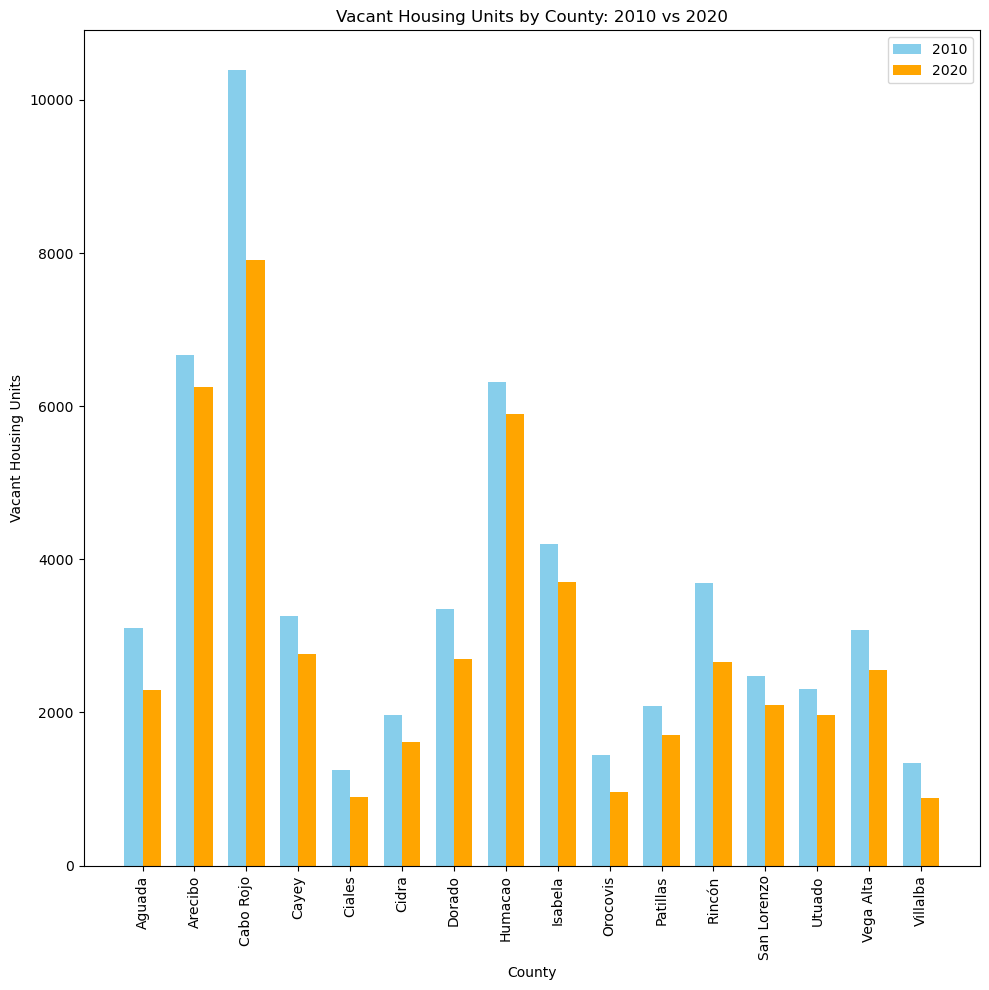

In [39]:
import numpy as np

counties = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1]["NAME"].tolist()
vacant_2010 = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1].groupby("NAME")["Vacant_2010"].sum()
vacant_2020 = pr_sedf[pr_sedf["Total_Vacant_Percentile"] == 1].groupby("NAME")["Vacant_2020"].sum()
x = np.arange(len(counties))

width = 0.35 #the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, vacant_2010.values, width, label='2010', color='skyblue')
rects2 = ax.bar(x + width/2, vacant_2020.values, width, label='2020', color='orange')


ax.set_ylabel('Vacant Housing Units')
ax.set_xlabel('County')
ax.set_title('Vacant Housing Units by County: 2010 vs 2020')
ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

<Axes: >

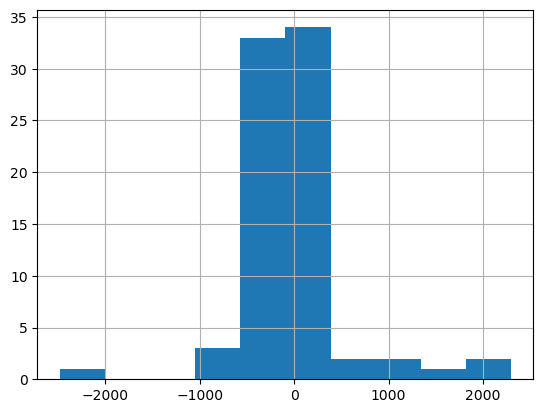

In [17]:
pr_sedf["Total_Vacant_Change"] .hist()

By looking more further into the histogram and difference bar chart between 2010 and 2020. We can have more confident that quantile classification did not do the right job at interpreation the data.

Reclassify by Standard Deviation Classification

In [34]:
#Unique Value Renderer


labels = ['< -2Std Dev', '-2 to -1Std Dev', '-1 to 0Std Dev', '0 to 1Std Dev', '1 to 2Std Dev', '> 2Std Dev']


symbol1 = SimpleFillSymbolEsriSFS(
    color = [140,81,10, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [216,179,101, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [246,232,195, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [199,234,229, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [90,180,172, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol6 = SimpleFillSymbolEsriSFS(
    color = [1,102,94, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
unique_value_infos = [
    UniqueValueInfo(
        value="< -2 Std Dev",
        label=labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value="-2 to -1 Std Dev",
        label=labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value="-1 to 0 Std Dev",
        label=labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value="0 to 1 Std Dev",
        label=labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value="1 to 2 Std Dev",
        label=labels[4],
        symbol=symbol5,
    ),
    UniqueValueInfo(
        value="> 2 Std Dev",
        label=labels[5],
        symbol=symbol6,
    )
]

std = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Change_Std",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

labeling_info = [
      {
        "labelExpression": "[NAME]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        "repeatLabel": True,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]

options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            "labelingInfo" : labeling_info,
            "renderer" : std.dict(),
        },
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",

}



In [35]:
m2 = Map("Puerto Rico")
m2.content.add(pr_sedf, options = options_dict)
m2.content.add(lecz, options={"opacity": 0.5})


## update the WebMap in Notebooks
m2.content.update_layer(
    index = 1,  #LECZ layer is added as the second layer
    options= {
        "title": "LECZ",
        "layerDefinition" : layer_def
    }
)
m2

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [36]:
m2.legend.enabled = True

Getting deeper to analyze what change in a county at block group level

In [ ]:
#Reading from zip file for block

current = os.getcwd()
DOWNLOAD_DIR = os.path.join(f"{current}/data")

file_list = os.listdir(DOWNLOAD_DIR)
csv_zip = [f for f in file_list if f.endswith('_csv.zip')]
shape_zip = [f for f in file_list if f.endswith('_shape.zip')]
csv = f"{DOWNLOAD_DIR}/{csv_zip[0]}" 
shapefile = f"{DOWNLOAD_DIR}/{shape_zip[1]}" #Block group shapefile
csv_data = ZipFile(csv).namelist()
shape_data = ZipFile(shapefile).namelist()

#Read csv data

with ZipFile(csv) as z:
    with z.open(csv_data[-1]) as f: 
        blck_grp_2020 = pd.read_csv(f)
    with z.open(csv_data[2]) as f:
        blck_grp_2010 = pd.read_csv(f)

In [ ]:
with ZipFile(shapefile) as outer_zip: # Shapefile data has 2 zipped layers
    with outer_zip.open(shape_data[0]) as inner_zip:
        with ZipFile(inner_zip) as inner:   
            inner.extractall(DOWNLOAD_DIR) #Extract the shapefile into the data folder

shp_df = pd.DataFrame.spatial.from_featureclass(location = "./data/PR_blck_grp_2020.shp", sr = 3857)
shp_df["COUNTYFP"] = shp_df["COUNTYFP"].str.replace(r"^0+", "", regex=True) #Remove leading zeros from the county codes
shp_df["COUNTYFP"] = shp_df["COUNTYFP"].astype(int) #Convert the county codes to int
shp_df["BLKGRPCE"] = shp_df["BLKGRPCE"].astype(int)

In [ ]:
#Aggregate the data by block group and county for 2010 and 2020

blck_grp_2010.rename(columns = rename_2010, inplace = True)
blck_grp_2020.rename(columns = rename_2020, inplace = True)

#Merge the dataframes for 2010 and 2020 by block group and county

blck_grp_merged = shp_df.merge(blck_grp_2020[["GISJOIN", "COUNTY", "Total_Housing_Units", "Occupied", "Vacant"]], on = ["GISJOIN"], how = "inner", suffixes=("_2010", "_2020"))

# blck_grp_shp = shp_df.merge(blck_grp_merged[["GISJOIN", "COUNTY", "COUNTYA", "BLKGRPA", "Total_Housing_Units_2020", "Occupied_2020", "Vacant_2020", "Total_Housing_Units_2010", "Occupied_2010", "Vacant_2010"]], on = "GISJOIN", how = "right")

# blck_grp_merged["Total_Vacant_Change"] = blck_grp_merged["Vacant_2020"] - blck_grp_merged["Vacant_2010"]


# #Doing the EDA
blck_grp_merged.isna().sum()   #Check for missing values


In [ ]:
# Create a dictionary with TRACTA as the primary key and BLKGRPA as secondary keys
tract_dict_2010 = {}


for _, row in blck_grp_2010.iterrows():
    tracta = row["TRACTA"]
    blkgrpa = row["BLKGRPA"]
    values = row.drop(["TRACTA", "BLKGRPA"]).to_dict()
    
    if tracta not in tract_dict_2010:
        tract_dict_2010[tracta] = {}
    
    tract_dict_2010[tracta][blkgrpa] = values

# Display the resulting dictionary
tract_dict_2010

In [ ]:
blck_grp_merged["Vacant_2010"] = 0 #Create a new column for the 2010 vacant housing units
blck_grp_merged["TRACTCE"] = blck_grp_merged["TRACTCE"].astype(int) 

for i in range(len(blck_grp_merged)):
    if blck_grp_merged["TRACTCE"][i] in tract_dict_2010:
        tract = blck_grp_merged["TRACTCE"][i]
        if blck_grp_merged["BLKGRPCE"][i] in tract_dict_2010[tract]:
            blk_grp = blck_grp_merged["BLKGRPCE"][i]
            blck_grp_merged["Vacant_2010"][i] = tract_dict_2010[tract][blk_grp]["Vacant"]

In [ ]:
# Create std mean for the data
blck_grp_merged["Total_Vacant_Change"] = blck_grp_merged["Vacant"] - blck_grp_merged["Vacant_2010"]


mean = blck_grp_merged["Total_Vacant_Change"].mean()
std = blck_grp_merged["Total_Vacant_Change"].std()

def classify_std(value, mean, std):
    if value < mean - 2*std:
        return "< -2 Std Dev"
    elif mean - 2*std <= value < mean - std:
        return "-2 to -1 Std Dev"
    elif mean - std <= value < mean:
        return "-1 to 0 Std Dev"
    elif mean <= value < mean + std:
        return "0 to 1 Std Dev"
    elif mean + std <= value < mean + 2*std:
        return "1 to 2 Std Dev"
    elif mean + 2*std <= value:
        return "> 2 Std Dev"

blck_grp_merged["Total_Vacant_Change_Std"] = blck_grp_merged["Total_Vacant_Change"].apply(lambda x: classify_std(x, mean, std))

In [ ]:
#Unique Value Renderer


labels = ['< -2Std Dev', '-2 to -1Std Dev', '-1 to 0Std Dev', '0 to 1Std Dev', '1 to 2Std Dev', '> 2Std Dev']


symbol1 = SimpleFillSymbolEsriSFS(
    color = [140,81,10, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
symbol2 = SimpleFillSymbolEsriSFS(
    color = [216,179,101, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol3 = SimpleFillSymbolEsriSFS(
    color = [246,232,195, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol4 = SimpleFillSymbolEsriSFS(
    color = [199,234,229, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol5 = SimpleFillSymbolEsriSFS(
    color = [90,180,172, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)

symbol6 = SimpleFillSymbolEsriSFS(
    color = [1,102,94, 255], 
    outline = SimpleLineSymbolEsriSLS(
        color = [153, 153, 153, 255], style = "esriSLSSolid", width = 0.5,
    ),
    style="esriSFSSolid",
    type="esriSFS",
)
unique_value_infos = [
    UniqueValueInfo(
        value="< -2 Std Dev",
        label=labels[0],
        symbol=symbol1,
    ),
    UniqueValueInfo(
        value="-2 to -1 Std Dev",
        label=labels[1],
        symbol=symbol2,
    ),
    UniqueValueInfo(
        value="-1 to 0 Std Dev",
        label=labels[2],
        symbol=symbol3,
    ),
    UniqueValueInfo(
        value="0 to 1 Std Dev",
        label=labels[3],
        symbol=symbol4,
    ),
    UniqueValueInfo(
        value="1 to 2 Std Dev",
        label=labels[4],
        symbol=symbol5,
    ),
    UniqueValueInfo(
        value="> 2 Std Dev",
        label=labels[5],
        symbol=symbol6,
    )
]

uvr = UniqueValueRenderer(
    type="uniqueValue",
    field1="Total_Vacant_Change_Std",
    uniqueValueInfos=unique_value_infos,
)

#Labeling info

labeling_info = [
      {
        "labelExpression": "[TRACTCE],[BLKGRPCE]",
        "labelPlacement": "esriServerPolygonPlacementAlwaysHorizontal",
        "repeatLabel": True,
        "symbol": {
          "type": "esriTS",
          "color": [
            0,
            0,
            0,
            255
          ],
          "font": {
            "family": "Arial",
            "size": 12
          },
          "horizontalAlignment": "center",
          "kerning": True,
        },
      }
]

options_dict = {
    "showLabels" : True,
    "layerDefinition" : {
        "drawingInfo" : {
            # "labelingInfo" : labeling_info,
            "renderer" : uvr.dict(),
        },
        "title" : "Puerto Rico Vacant Housing Change",
    },
    "opacity" : 0.5,
    "title" : "Vacant Housing Units Decadal Change",
}



In [ ]:
county = "Cabo Rojo"

county_filter = blck_grp_merged[blck_grp_merged["COUNTY"] == f"{county} Municipio"]

m3 = Map(f"{county}, PR")
m3.content.add(county_filter, options = options_dict)
m3.content.add(lecz, options={"opacity": 0.5})
m3
# update the WebMap in Notebooks
m3.content.update_layer(
    index = 1, 
    options= {
        "title": "LECZ",
        "layerDefinition" : layer_def
    }
)   

In [ ]:
m3

In [ ]:
m3.legend.enabled = True